# Meat classification with _kShape_

<div style="width: 130px ; float: right"><img src="https://bit.ly/2ICpwel" alt="drawing"><p style="font-size: 10px ; text-align: center; margin: 0px 0px">Illustration by David Feiss</p></div>

Data sequence clustering algorithms groups series based on their shapes. An important feature regarding clustering algorithms is their ability to deal with subtle changes in shapes; in some cases, being able to identify small shape variations in a set is key to correctly produce the most appropriate clusters for our data.

In this example, we use [Khiva's](https://khiva-python.readthedocs.io/en/latest/) implementation of [_kShape_](http://www.cs.columbia.edu/~gravano/Papers/2017/tods17.pdf) to classify different types of meat. _kShape_ outperforms other algorithms like _kMeans_, as it obtains better results due to the lack of dependence on scale and shifting. In this use-case, we run both algorithms and compare their results.

We have chosen a [Meat Dataset](http://www.timeseriesclassification.com/description.php?Dataset=Meat) containing 60 samples. Each series is obtained by a spectograph and we have different kind of meat: chicken, pork or turkey. These spectrographs are used in chemometrics to classify food types, with real application in food safety and quality assurance.

The objective of this use case is to use Khiva's implementation of _kShape_ and _kMeans_ to cluster the results of the spectrograph.
<div style="text-align: right"> <font size="1"> Illustration by David Feiss </font></div>

In [ ]:
import khiva as kv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from ipywidgets import interact, IntSlider

## Visualising the dataset

Firstly, let's load the training dataset and plot all samples in a single chart.

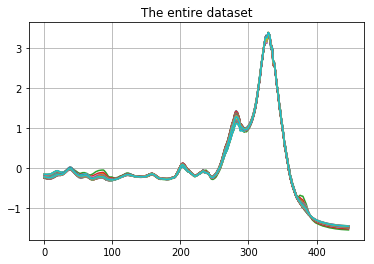

In [8]:
data = pd.read_csv("Meat_TRAIN.txt", header=None, sep=' ')

data = data.values
classes = data[:,0]
data = np.delete(data, 0, 1)

plt.plot(data.transpose())
plt.grid(True)
plt.title("The entire dataset")
plt.show()

As we can see, it is hardly impossible to perform an accurate classification by visual inspection, as there are no key differences between the different kinds of meat.

## Clustering with _kShape_

Let's run _kShape_ algorithm first. _Khiva_ implementation will compute the centroids for each group automatically. These centroids keep the key characteristics for each group, like shift, scale and shape, thanks to a specialised data series distance metric called SBD (in reality, it is a dissimilarty distance), which takes into account the actual shape of the series.

In [ ]:
k=3
titles = ["First cluster", "Second cluster", "Third cluster"]

cen = np.array([])
lab = np.array([])

def num_iter_variation(num_iter):
    (centroids, labels) = kv.k_shape(kv.Array(data), k, max_iterations=num_iter)

    global cen
    global lab
    cen = centroids.to_numpy()
    lab = labels.to_numpy()

    for i in range(k):
        cond = lab == i
        if np.any(cond):
            plt.plot(data[lab == i, :].transpose())
            plt.plot(cen[i, :], label="centroid", c='k')
            plt.title(titles[i])
            plt.grid(True)
            plt.show()
interact(num_iter_variation, num_iter=IntSlider(min=1, max=10, step=1), continuous_update=False)

interactive(children=(IntSlider(value=1, description='num_iter', max=10, min=1), Output()), _dom_classes=('wid…

<function __main__.num_iter_variation(num_iter)>

Move the slider button to change the number of iterations and check how this impact on _k-shapes_ accuracy! You can also analyse the statistics corresponding to this classification with a summary of results.

In [ ]:
# This cell computes the accuracy of KShape
mapping_shape = dict([(1, stats.mode(lab[np.where(classes == 1)]).mode[0]), (2, stats.mode(lab[np.where(classes == 2)]).mode[0]), (3, stats.mode(lab[np.where(classes == 3)]).mode[0])])

group1 = lab[classes == 1]
count_well_group1 = group1[group1 == mapping_shape[1]].size

group2 = lab[classes == 2]
count_well_group2 = group2[group2 == mapping_shape[2]].size

group3 = lab[classes == 3]
count_well_group3 = group3[group3 == mapping_shape[3]].size

well_classified = count_well_group1 + count_well_group2 + count_well_group3
total = len(classes)

print("KShape accuracy " + str(well_classified/total))

## Clustering using _KMeans_

Now, we are going to execute the same analysis but using _Scikit's_ _kMeans_ implementation, so we can benchmark its accuracy against _KShape_.

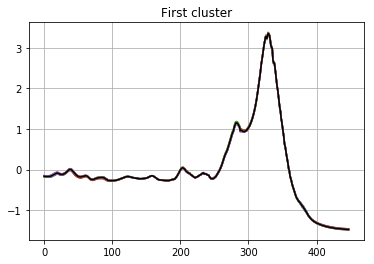

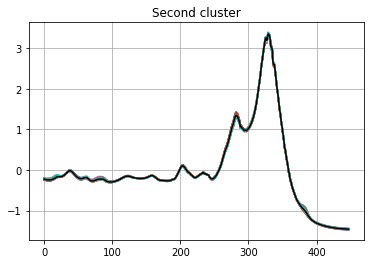

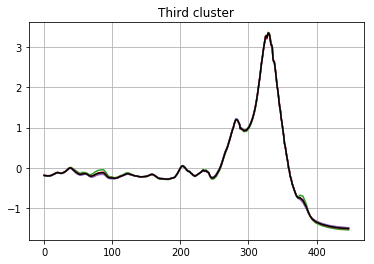

In [10]:
km = KMeans(n_clusters=k).fit(data)
for i in range(k):
    cond = km.labels_ == i
    if np.any(cond):
        plt.plot(data[km.labels_ == i, :].transpose())
        plt.plot(km.cluster_centers_[i, :], label="centroid", c='k')
        plt.title(titles[i])
        plt.grid(True)
        plt.show()

In [ ]:
# This cell computes the accuracy of KMeans
mapping_means = dict([(1, stats.mode(km.labels_[np.where(classes == 1)]).mode[0]), (2, stats.mode(km.labels_[np.where(classes == 2)]).mode[0]), (3, stats.mode(km.labels_[np.where(classes == 3)]).mode[0])])

group1 = lab[classes == 1]
count_well_group1 = group1[group1 == mapping_means[1]].size

group2 = lab[classes == 2]
count_well_group2 = group2[group2 == mapping_means[2]].size

group3 = lab[classes == 3]
count_well_group3 = group3[group3 == mapping_means[3]].size

well_classified = count_well_group1 + count_well_group2 + count_well_group3
total = len(classes)

print("KMeans accuracy " + str(well_classified/total))

## Visualising the clusters with _kShape_

Now that we have computed the clusters using _kShape_, we can plot the set of time series belonging to the first cluster, along with the first centroid (black line). Looking at the graph, it is easy to conclude that the centroid summarises the shape of all the time series belonging to this first cluster. Besides, we show the analogue graph for the second cluster.

In [11]:
def _ncc_c_3dim(x, y):
    den = np.linalg.norm(x, axis=1)[:, None] * np.linalg.norm(y, axis=1)
    den[den == 0] = np.Inf
    x_len = x.shape[-1]
    fft_size = 1 << (2*x_len-1).bit_length()
    cc = np.fft.ifft(np.fft.fft(x, fft_size) * np.conj(np.fft.fft(y, fft_size))[:, None])
    cc = np.concatenate((cc[:,:,-(x_len-1):], cc[:,:,:x_len]), axis=2)
    return np.real(cc) / den.T[:, :, None]

test = pd.read_csv("Meat_TEST.txt", header = None, sep=' ')
test = test.values

test_classes = test[:,0]
test = np.delete(test, 0, 1)

distances = np.empty((cen.shape[0], test.shape[0]))

for i in range(test.shape[0]):
    for j in range(cen.shape[0]):
        distances[j, i] = np.sum(np.abs(test[i,:] - cen[j, :]))

idx_test = np.argmin(distances, 0)

distances_NCC = (1 - _ncc_c_3dim(test, cen).max(axis=2)).T
idx_test_ncc = distances_NCC.argmin(1)

test_group1 = idx_test_ncc[np.where(test_classes == 1)]
test_group2 = idx_test_ncc[np.where(test_classes == 2)]
test_group3 = idx_test_ncc[np.where(test_classes == 3)]


well_classified1 = test_group1[test_group1 == mapping_shape[1]].size
well_classified2 = test_group1[test_group2 == mapping_shape[2]].size
well_classified3 = test_group1[test_group3 == mapping_shape[3]].size
well_classified_total = well_classified1 + well_classified2 + well_classified3

print("KShape accuracy with the test dataset: " + str(well_classified_total/len(test_classes)))

FileNotFoundError: File b'Meat_TEST.txt' does not exist

Considering the previous results, it becomes apparent that using a specialised algorithm for data series delivers better clustering insights, rather than those obtain using a more generalized algorithm like _kMeans_.

Give a try to Khiva's _kShape_ implementation on your dataset. Share with us the results obtained and make a pull request to publish them!.